In [486]:
from importlib import reload
import os
from toolz import pipe as p

import matplotlib.pyplot as plt
import numpy as np

from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import trainModel
import visualizeModel

In [487]:
%matplotlib inline

In [488]:
x = torch.randn(1)

In [489]:
device = torch.device("cuda")

In [490]:
x.to(device)

tensor([-1.3983], device='cuda:0')

# Chose Model

In [556]:
reload(trainModel)

n_classes = p('scrap_data/train/', os.listdir, len)

model, input_size = trainModel.initialize_model("resnet", n_classes,
                                               True)

model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Load Images

In [557]:
reload(trainModel)
data_transforms = trainModel.create_data_transforms(input_size, input_size)

In [558]:
data_dir = 'scrap_data/'
xs = ['train', 'val']

image_datasets = {x: p(data_dir, 
                       lambda _:os.path.join(_, x),
                       lambda _: datasets.ImageFolder(_, data_transforms[x])
                      )
                  for x in xs}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers = 4)
               for x in xs}

dataset_sizes = {x: len(image_datasets[x]) for x in xs}

In [559]:
class_names = image_datasets['train'].classes

In [560]:
class_names

['gossiping',
 'isolation',
 'laughing',
 'nonbullying',
 'pullinghair',
 'punching',
 'quarrel',
 'slapping',
 'stabbing',
 'strangle']

In [561]:
dataset_sizes

{'train': 1000, 'val': 400}

# Visualize

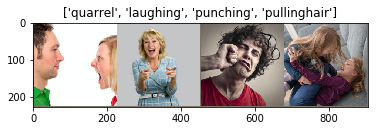

In [562]:
reload(visualizeModel)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

visualizeModel.imshow(out, mn, sd, 
                      title=[class_names[x] for x in classes])

# Finetune Convnet

In [563]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [564]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [568]:
reload(trainModel)
trainModel.viewParamsToBeUpdated(model)

['layer4.1.conv2.weight', 'layer4.1.bn2.weight', 'fc.weight', 'fc.bias']

In [569]:
reload(trainModel)

model = trainModel.train_model(
    model, criterion, optimizer, exp_lr_scheduler, dataloaders, 
    dataset_sizes,
    device, num_epochs=25)

Epoch 0/24
----------
train Loss: 14.1701 Acc: 0.2530
val Loss: 4.8986 Acc: 0.4775
Epoch 1/24
----------
train Loss: 9.7952 Acc: 0.3480
val Loss: 10.5230 Acc: 0.3100
Epoch 2/24
----------
train Loss: 8.2856 Acc: 0.4280
val Loss: 17.7999 Acc: 0.3850
Epoch 3/24
----------
train Loss: 9.4954 Acc: 0.4510
val Loss: 13.5195 Acc: 0.3850
Epoch 4/24
----------
train Loss: 9.5326 Acc: 0.4420
val Loss: 9.6020 Acc: 0.4825
Epoch 5/24
----------
train Loss: 9.0788 Acc: 0.4870
val Loss: 10.4345 Acc: 0.4950
Epoch 6/24
----------
train Loss: 11.7816 Acc: 0.4660
val Loss: 7.4776 Acc: 0.6025
Epoch 7/24
----------
train Loss: 3.3145 Acc: 0.7020
val Loss: 3.6267 Acc: 0.6475
Epoch 8/24
----------
train Loss: 2.0917 Acc: 0.6950
val Loss: 2.6173 Acc: 0.6725
Epoch 9/24
----------
train Loss: 1.4285 Acc: 0.7230
val Loss: 2.6235 Acc: 0.6150
Epoch 10/24
----------
train Loss: 1.1338 Acc: 0.7270
val Loss: 1.9481 Acc: 0.6525
Epoch 11/24
----------
train Loss: 1.0521 Acc: 0.7370
val Loss: 1.6139 Acc: 0.6675
Epoch 12

## Visualize Results

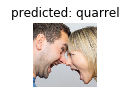

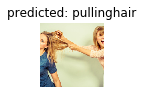

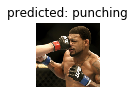

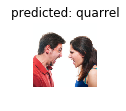

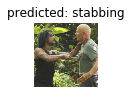

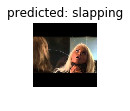

In [502]:
reload(trainModel)
trainModel.visualize_model(model, dataloaders, device, class_names, 
                           trainModel.defaultMn, 
                           trainModel.defaultSd, k='val')

# Hyper Parameter Search

In [589]:
get_run_dir_name = lambda model: p(model, 
                                   trainModel.viewParamsToBeUpdated, 
                                   lambda _: '-'.join(_), 
                                   str,
                                   lambda _: 'runs/' + _)

In [595]:
get_run_dir_name(model)

'runs/layer4.1.conv2.weight-layer4.1.bn2.weight-fc.weight-fc.bias'

In [596]:
trainModel.viewParamsToBeUpdated(model)

['layer4.1.conv2.weight', 'layer4.1.bn2.weight', 'fc.weight', 'fc.bias']

In [597]:
len(trainModel.findParam(model, ['fc.weight']))

1

In [602]:
reload(trainModel)

run_params = [
    [('fc', 'weight'), ('fc', 'bias')],
    [('layer4', '1', 'bn2')],
    [('layer4', '1', 'bn2'), ('layer4', '1', 'conv2')]
]


for params in run_params:  
    model, input_size = trainModel.initialize_model("resnet", n_classes,
                                               True)
    model = model.to(device)
    
    for nc in params:
        (_, param) = trainModel.findParam(model, nc)[0]
        param.requires_grad_(True)
        
    writer = p(model, get_run_dir_name, SummaryWriter)
    
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model = trainModel.train_model(
        model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes,
        device, num_epochs=25)

Epoch 0/24
----------
train Loss: 60.6818 Acc: 0.2750
val Loss: 31.2095 Acc: 0.4975
Epoch 1/24
----------
train Loss: 57.6919 Acc: 0.3870
val Loss: 45.4169 Acc: 0.5150
Epoch 2/24
----------
train Loss: 47.6805 Acc: 0.4670
val Loss: 36.5003 Acc: 0.5650
Epoch 3/24
----------
train Loss: 45.8997 Acc: 0.4670
val Loss: 42.6534 Acc: 0.5375
Epoch 4/24
----------
train Loss: 46.3031 Acc: 0.4860
val Loss: 49.3077 Acc: 0.5700
Epoch 5/24
----------
train Loss: 48.6087 Acc: 0.5250
val Loss: 70.0622 Acc: 0.4900
Epoch 6/24
----------
train Loss: 45.5008 Acc: 0.5370
val Loss: 96.2394 Acc: 0.4400
Epoch 7/24
----------
train Loss: 26.3599 Acc: 0.6370
val Loss: 37.8182 Acc: 0.6475
Epoch 8/24
----------
train Loss: 20.8916 Acc: 0.6840
val Loss: 37.6014 Acc: 0.6175
Epoch 9/24
----------
train Loss: 18.6767 Acc: 0.6920
val Loss: 33.2120 Acc: 0.6450
Epoch 10/24
----------
train Loss: 19.1169 Acc: 0.6840
val Loss: 36.0735 Acc: 0.6225
Epoch 11/24
----------
train Loss: 20.0402 Acc: 0.6690
val Loss: 32.0645 Ac